In [1]:
import time
import argparse
import random
import os
import warnings
from importlib import import_module
import cv2


warnings.filterwarnings('ignore')

import torch
import numpy as np
from tqdm import tqdm

from datasets.data_loader import setup_loader
from datasets.data_loader import CustomDataLoader2, CustomDataLoader3, CustomDataLoader4
from config import Config
import matplotlib.pyplot as plt

In [2]:
import glob

from src.create_annotations_custom import *

# Label ids of the dataset
category_ids = {
    "UNKNOWN": 0,
    "General trash": 1,
    "Paper": 2,
    "Paper pack": 3,
    "Metal": 4,
    "Glass": 5,
    "Plastic": 6,
    "Styrofoam": 7,
    "Plastic bag": 8,
    "Battery": 9,
    "Clothing": 10
}

category_colors = {
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
    "6": 6,
    "7": 7,
    "8": 8,
    "9": 9,
    "10": 10
}

multipolygon_ids = [0]

def images_annotations_info(file_name, mask, id, image_id, annotation_id):
    # This id will be automatically increased as we go
    annotations = []
    images = []

    # Open the image and (to be sure) we convert it to RGB

    w, h = mask.shape

    # "images" info
    image = create_image_annotation(file_name, w, h, image_id)
    images.append(image)

    sub_masks = create_sub_masks(mask, w, h)
    for cat, sub_mask in sub_masks.items():
        category_id = cat
        # "annotations" info
        polygons, segmentations = create_sub_mask_annotation(sub_mask)

        # Check if we have classes that are a multipolygon
        if category_id in multipolygon_ids:
            # Combine the polygons to calculate the bounding box and area
            multi_poly = MultiPolygon(polygons)

            annotation = create_annotation_format(multi_poly, segmentations, image_id, category_id, annotation_id)

            annotations.append(annotation)
            annotation_id += 1
        else:
            for i in range(len(polygons)):
                # Cleaner to recalculate this variable
                segmentation = [np.array(polygons[i].exterior.coords).ravel().tolist()]

                annotation = create_annotation_format(polygons[i], segmentation, image_id, category_id, annotation_id)

                annotations.append(annotation)
                annotation_id += 1
    image_id += 1

    return images, annotations, annotation_id

In [3]:
config = Config(
    lr=0.0001,
    epochs=20,
    batch_size=8,
    seed=21,
    eval=False,
    augmentation='CustomAugmentation7',
    criterion='cross_entropy',
    optimizer='adam',
    model='unetmnv2',
    continue_load='',
    eval_load='',
    dataset_path='../input/data')

Config(lr=0.0001, epochs=20, batch_size=8, seed=21, eval=False, augmentation='CustomAugmentation7', criterion='cross_entropy', optimizer='adam', model='unetmnv2', eval_load='', continue_load='', dataset_path='../input/data')
pytorch version: 1.6.0
GPU 사용 가능 여부: True
Tesla P40
1
Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


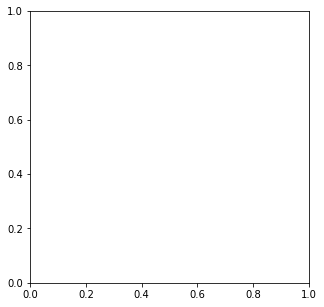

In [4]:
print(config)

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"  # GPU 사용 가능 여부에 따라 device 정보 저장

sorted_df = setup_loader(config)

# train.json / validation.json / test.json 디렉토리 설정
train_path = config.dataset_path + '/train.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
augmentation_module = getattr(import_module("transforms.Augmentations"), config.augmentation)
train_transform = augmentation_module(mode='train')
train_dataset = CustomDataLoader4(data_dir=train_path, sorted_df=sorted_df, mode='train', transform=train_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=config.batch_size,
                                          num_workers=2,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.43s)
creating index...
index created!


Start extracting..
torch.Size([3, 512, 512])
(512, 512)
{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0003.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 0}
[{'id': 0, 'image_id': 0, 'category_id': 8, 'segmentation': [[184, 455, 183, 455, 182, 455, 181, 455, 181, 454, 180, 454, 180, 453, 179, 453, 179, 452, 178, 452, 178, 451, 177, 451, 177, 450, 176, 450, 176, 449, 175, 449, 175, 448, 174, 448, 174, 447, 173, 447, 172, 447, 172, 446, 171, 446, 171, 445, 170, 445, 170, 444, 169, 444, 169, 443, 168, 443, 168, 442, 167, 442, 167, 441, 166, 441, 166, 440, 166, 439, 165, 439, 165, 438, 164, 438, 164, 437, 163, 437, 163, 436, 163, 435, 162, 435, 162, 434, 161, 434, 161, 433, 160, 433, 160, 432, 159, 432, 158, 432, 157, 432, 156, 432, 155, 432, 154, 432, 153, 432, 152, 432, 152, 431, 151, 431, 150, 431, 149, 431, 148, 431, 147, 432, 147, 432, 146, 433, 146, 433, 145, 433, 145, 432, 144, 432, 143, 432, 143, 431, 142, 431, 141, 431, 140, 431, 140, 430, 139, 430, 138, 4

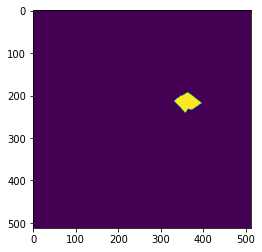

In [6]:

print('Start extracting..')
for images, masks_lists, informs, annses in iter(train_loader):
    # images = torch.stack(images)  # (batch, channel, height, width)
    # masks = torch.stack(masks).long()  # (batch, channel, height, width)
    B = config.batch_size
    # print(cocoImgs)
    for i in range(B):
        image = images[i]
        masks_list = masks_lists[i]
        inform = informs[i]
        anns = annses[i]
        plt.imshow(masks_list[1])
        print(image.shape)
        print(masks_list[0].shape)
        print(inform)
        print(anns)
        break
    break

In [7]:
ti = 204
print(f"{ti+1}")
print(f"{ti+1:05}")

205
00205


In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from glob import glob

coco_format = get_coco_json_format()

# Create category section
coco_format["categories"] = create_category_annotation(category_ids)

backgrounds = glob(os.path.join('../input/data', 'results_splits/') + '*.jpg')
backgrounds_len = len(backgrounds)

if not os.path.exists('object_alones'):
    os.mkdir('object_alones')

image_id = 0
annotation_id = 0

toTensorV2 = ToTensorV2(transpose_mask=True)

for images, masks_lists, informs, annses in tqdm(iter(train_loader), total=len(train_loader)):
    B = config.batch_size
    for i in range(B):
        image = images[i]
        masks_list = masks_lists[i]
        inform = informs[i]
        anns = annses[i]
        # fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
        # ax1.imshow(image.permute([1, 2, 0]))
        # ax2.imshow(masks_list[1])

        for j in range(len(anns)):
            # cv2 를 활용하여 image 불러오기
            bgint = random.randint(0,backgrounds_len-1)
            background = cv2.cvtColor(cv2.imread(backgrounds[bgint]), cv2.COLOR_BGR2RGB)
            mask = masks_list[j]
            transformed = toTensorV2(image=background, mask=mask)
            background = transformed['image']
            mask = transformed['mask']

            background_object = torch.where(mask>0, image, background)

            image_savefilename = f'object_alones/{image_id+1:05}.jpg'
            temp_image = dict()
            temp_image['license'] = 0
            temp_image['url'] = None
            temp_image['file_name'] = image_savefilename
            temp_image['height'] = 512
            temp_image['width'] = 512
            temp_image['date_captured'] = None
            temp_image['id'] = image_id
            
            temp_anno = dict()
            temp_anno['id'] = annotation_id
            temp_anno['image_id'] = image_id
            temp_anno['category_id'] = anns[j]['category_id']
            temp_anno['segmentation'] = anns[j]['segmentation']
            temp_anno['area'] = anns[j]['area']
            temp_anno['bbox'] = anns[j]['bbox']
            temp_anno['iscrowd'] = anns[j]['iscrowd']

            coco_format["images"].append(temp_image)
            coco_format["annotations"].append(temp_anno)
            
            cv2.imwrite(image_savefilename, background_object.permute([1, 2, 0]).numpy())
            # ax3.imshow(background_object.permute([1, 2, 0]))
            image_id += 1
            annotation_id += 1


        # ax3.imshow(background)
        # ax4.imshow(mask)

        # plt.show()

with open("split_sample.json","w") as outfile:
    json.dump(coco_format, outfile, indent=4)

print("Created %d annotations for images in folder: %s" % (0, 'mask'))


Created 0 annotations for images in folder: mask
